# Amazon Beauty & Personal Care Reviews – Sentiment Classification

**Course:** CSE 158

**Dataset:** Amazon Reviews 2023 – *Beauty and Personal Care*  

# 1. Introduction

This project focuses on sentiment classification for Amazon Beauty & Personal Care reviews. 
Each review comes with free-form text and a 1–5 star rating. We convert this into a binary label:

- **Positive**: rating ≥ 4  
- **Negative**: rating ≤ 3  

The key challenge is that the dataset is **highly imbalanced** (≈75% positive), which makes simple 
accuracy misleading. The goal is therefore to build and compare several text-based models that 
can correctly identify the minority (negative) class.

We evaluate all models on held-out validation and test splits and compare them using accuracy, 
precision, recall, F1, AUC, and confusion matrices.

In [ ]:
!pip install pandas numpy matplotlib seaborn scikit-learn joblib

In [34]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    roc_auc_score,
    confusion_matrix,
    roc_curve,
    classification_report,   
)

from sklearn.pipeline import Pipeline
from collections import Counter


RANDOM_STATE = 42
plt.style.use("default")


In [35]:
df = pd.read_csv("df_ready.csv")
print(df.head())
print("\nShape:", df.shape)

                                                                                                                                                                                                      text  \
0  this product is great for the skin.  i have dryness on my legs and within a day or two my legs were smooth as can be.  i use it right after a shower.  i also really like that it comes with a pump ...   
1                                                                                                                     this worked after the first night my feet are so smooth i would highly recommend it!   
2                                                                                      i really liked this body wash.  it has a nice smell and thickness and washes off your body easily.  will buy again.   
3  i love this shampoo and conditioner (i have purchased both). first, i love the scent. lightly peppermint and lavender, it fills my shower with the most amazing calming fragr

## 1. Dataset Summary

We use the **Beauty and Personal Care** subset of the Amazon Reviews 2023 dataset.  
From the full 23.9M reviews, we sampled approximately 1% and cleaned it to obtain `df_ready.csv`.

Each row contains:
- `text`: the review text
- `title`: review title
- `rating`: original star rating (1–5)
- `user_id`: reviewer ID
- `asin`: product ID
- `label`: binary sentiment label  
  - `1` = positive (rating ≥ 4)  
  - `0` = negative (rating ≤ 3)

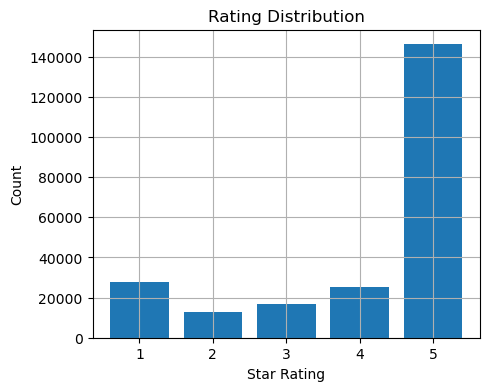

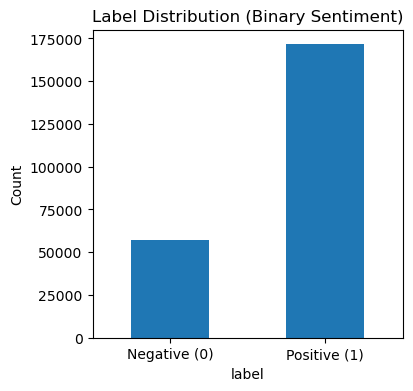

label
0    0.249706
1    0.750294
Name: count, dtype: float64

In [36]:
if "rating" in df.columns:
    plt.figure(figsize=(5,4))
    df["rating"].hist(bins=[1,2,3,4,5,6], align="left", rwidth=0.8)
    plt.xlabel("Star Rating")
    plt.ylabel("Count")
    plt.title("Rating Distribution")
    plt.show()

plt.figure(figsize=(4,4))
label_counts = df["label"].value_counts().sort_index()
label_counts.plot(kind="bar")
plt.xticks([0,1], ["Negative (0)", "Positive (1)"], rotation=0)
plt.ylabel("Count")
plt.title("Label Distribution (Binary Sentiment)")
plt.show()

label_counts / label_counts.sum()

### Interpretation

The rating distribution is heavily skewed toward 5-star reviews, which is expected for Amazon 
products. After converting ratings to a binary label, roughly **75% of reviews are positive**. 
This imbalance helps explain why a majority-class baseline already achieves ~75% accuracy. 
Because of this, metrics like F1 and recall for the negative class are especially important.


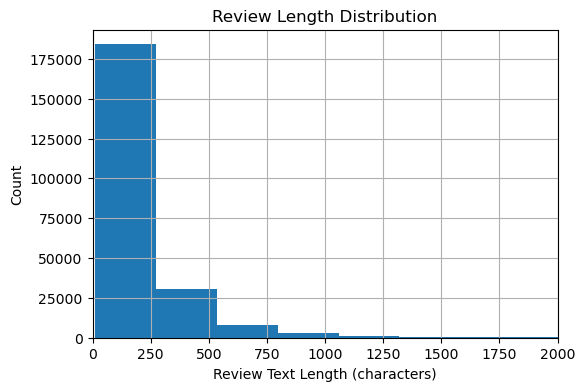

count    228581.000000
mean        186.039093
std         246.570572
min          11.000000
25%          52.000000
50%         114.000000
75%         227.000000
max       13098.000000
Name: text_len, dtype: float64

In [37]:
df["text_len"] = df["text"].str.len()

plt.figure(figsize=(6,4))
df["text_len"].hist(bins=50)
plt.xlabel("Review Text Length (characters)")
plt.ylabel("Count")
plt.title("Review Length Distribution")
plt.xlim(0, 2000)
plt.show()

df["text_len"].describe()


Most reviews fall between 50 and 250 characters. The long tail of very long reviews suggests 
that TF-IDF will produce a high-dimensional sparse matrix, but Logistic Regression and Linear SVM 
handle this well.


## 2. Sample Reviews
Below are a few example reviews from the dataset.


In [38]:
pd.set_option("display.max_colwidth", 200)
df[["title","rating", "label", "text"]].sample(5, random_state=100)

,title,rating,label,text
36251,it us very expensive but people do not stop complimenting the light fragrance. it lasts for hours.,5.0,1,the value is great but i had to think long and hard about buying it because of budget restraints.
53484,five stars,5.0,1,love the scrub.
157429,four stars,4.0,1,does the best job out of any i've purchased for my husband. would recommend.
25495,five stars,5.0,1,works great have bought multiple now.
92681,great color,5.0,1,i’ve been using this color for years. my hair is light brown with blonde highlights. it’s the only pencil color that’s worked for me.


In [39]:
# Simple token frequency (just for EDA; TF-IDF will be more rigorous later)
def tokenize(s):
    return s.split()

sample_texts = df["text"].sample(20000, random_state=42)
counter = Counter()

for t in sample_texts:
    counter.update(tokenize(t))

most_common = counter.most_common(20)
most_common


[('the', 26646),
 ('i', 26074),
 ('and', 21667),
 ('it', 18476),
 ('a', 16386),
 ('to', 15749),
 ('my', 12543),
 ('this', 12506),
 ('is', 10535),
 ('for', 9488),
 ('of', 7800),
 ('but', 6117),
 ('in', 5946),
 ('not', 5772),
 ('on', 5530),
 ('have', 5367),
 ('with', 5275),
 ('that', 5155),
 ('was', 5133),
 ('so', 4848)]

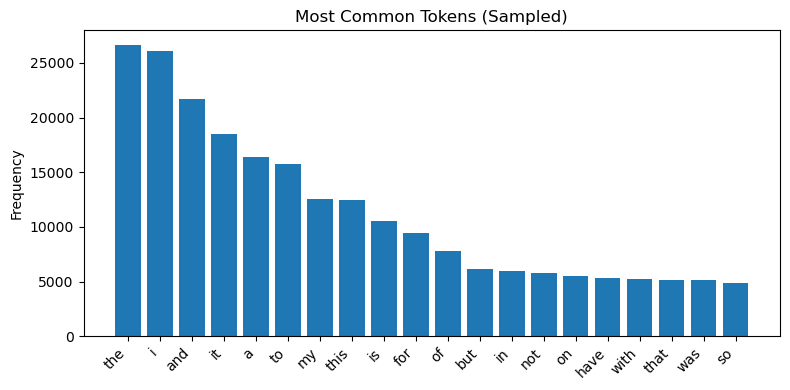

In [40]:
words, counts = zip(*most_common)
plt.figure(figsize=(8,4))
plt.bar(words, counts)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Frequency")
plt.title("Most Common Tokens (Sampled)")
plt.tight_layout()
plt.show()


The  most frequent tokens are stopwords and function words. This means that TF-IDF is a great fit, which pputs less emphasis on these types of words andgives more weight to the meaningful word 
patterns. We expect that sentiment-bearing bigrams (e.g., "highly recommend", "very disappointed") 
will be useful later.


## 3. Predictive Task



**Goal:**  
Given the text of a review, predict whether the underlying rating is **positive (≥4 stars)** or **negative (≤3 stars)**.

**Input features:**
- `text` (main feature, free-form review text)
- Optionally, `title` can be concatenated to `text` (not strictly necessary)

**Target:**
- `label ∈ {0,1}`  
  - `0`: negative review  
  - `1`: positive review

This is a **binary classification** problem. We evaluate models using:

- Accuracy  
- Precision, Recall, F1  
- ROC–AUC  
- Confusion matrix


In [41]:
X = df["text"].astype(str).values
y = df["label"].values

# 80 / 10 / 10 split with stratification
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y
)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, test_size=0.1111, random_state=42, stratify=y_train_full
)

print("Train size:", len(X_train))
print("Valid size:", len(X_valid))
print("Test size: ", len(X_test))


Train size: 182866
Valid size: 22856
Test size:  22859


### 3.1 Classical Models: TF-IDF + Logistic Regression Variants

To understand how different feature scopes and regularization types affect performance, 
we trained four Logistic Regression models:

- **Unigrams + L2**  
- **Unigrams + L1**  
- **Unigrams + Bigrams + L2**  
- **Unigrams + Bigrams + L1**

Bigram features allow the model to capture short sentiment phrases, while L1 encourages sparsity 
and L2 encourages more distributed weights. All models use class weighting to compensate for the 
label imbalance.


In [42]:
def build_logreg_models():
    """
    Four TF-IDF + Logistic Regression baselines:

    - tfidf_uni_l2: unigrams, L2 penalty
    - tfidf_uni_l1: unigrams, L1 penalty
    - tfidf_uni_bi_l2: uni+bi-grams, L2 penalty
    - tfidf_uni_bi_l1: uni+bi-grams, L1 penalty
    """
    models = {}

    # 1. TF-IDF (unigrams) + L2
    models["tfidf_uni_l2"] = Pipeline(
        [
            (
                "tfidf",
                TfidfVectorizer(
                    ngram_range=(1, 1),
                    min_df=5,
                    max_df=0.95,
                ),
            ),
            (
                "clf",
                LogisticRegression(
                    penalty="l2",
                    solver="liblinear",
                    max_iter=1000,
                    class_weight="balanced",
                ),
            ),
        ]
    )

    # 2. TF-IDF (unigrams) + L1
    models["tfidf_uni_l1"] = Pipeline(
        [
            (
                "tfidf",
                TfidfVectorizer(
                    ngram_range=(1, 1),
                    min_df=5,
                    max_df=0.95,
                ),
            ),
            (
                "clf",
                LogisticRegression(
                    penalty="l1",
                    solver="liblinear",
                    max_iter=1000,
                    class_weight="balanced",
                ),
            ),
        ]
    )

    # 3. TF-IDF (uni+bi) + L2
    models["tfidf_uni_bi_l2"] = Pipeline(
        [
            (
                "tfidf",
                TfidfVectorizer(
                    ngram_range=(1, 2),
                    min_df=5,
                    max_df=0.95,
                ),
            ),
            (
                "clf",
                LogisticRegression(
                    penalty="l2",
                    solver="liblinear",
                    max_iter=1000,
                    class_weight="balanced",
                ),
            ),
        ]
    )

    # 4. TF-IDF (uni+bi) + L1
    models["tfidf_uni_bi_l1"] = Pipeline(
        [
            (
                "tfidf",
                TfidfVectorizer(
                    ngram_range=(1, 2),
                    min_df=5,
                    max_df=0.95,
                ),
            ),
            (
                "clf",
                LogisticRegression(
                    penalty="l1",
                    solver="liblinear",
                    max_iter=1000,
                    class_weight="balanced",
                ),
            ),
        ]
    )

    return models


def evaluate_split(split_name, y_true, y_pred, y_scores=None):
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="binary", zero_division=0
    )
    print(f"\n[{split_name}]")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1       : {f1:.4f}")

    if y_scores is not None:
        try:
            roc = roc_auc_score(y_true, y_scores)
            print(f"ROC-AUC  : {roc:.4f}")
        except ValueError:
            print("ROC-AUC could not be computed (only one class).")

    print("Confusion matrix (rows=true, cols=pred):")
    print(confusion_matrix(y_true, y_pred))


logreg_models = build_logreg_models()

extra_results = []  # will feed into the big summary table later

for name, model in logreg_models.items():
    print(f"\n=== Training model: {name} ===")
    model.fit(X_train, y_train)

    # Validation
    y_val_pred = model.predict(X_valid)
    y_val_scores = model.predict_proba(X_valid)[:, 1]
    evaluate_split(f"Validation – {name}", y_valid, y_val_pred, y_val_scores)

    # Test
    y_test_pred_extra = model.predict(X_test)
    y_test_scores_extra = model.predict_proba(X_test)[:, 1]
    evaluate_split(f"Test – {name}", y_test, y_test_pred_extra, y_test_scores_extra)

    # store metrics for the results summary
    acc = accuracy_score(y_test, y_test_pred_extra)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_test, y_test_pred_extra, average="binary", zero_division=0
    )
    auc = roc_auc_score(y_test, y_test_scores_extra)

    extra_results.append(
        {
            "model": name,
            "acc_test": acc,
            "prec_test": prec,
            "rec_test": rec,
            "f1_test": f1,
            "auc_test": auc,
        }
    )

extra_results = pd.DataFrame(extra_results)
extra_results



=== Training model: tfidf_uni_l2 ===

[Validation – tfidf_uni_l2]
Accuracy : 0.8768
Precision: 0.9575
Recall   : 0.8747
F1       : 0.9142
ROC-AUC  : 0.9479
Confusion matrix (rows=true, cols=pred):
[[ 5041   666]
 [ 2149 15000]]

[Test – tfidf_uni_l2]
Accuracy : 0.8769
Precision: 0.9581
Recall   : 0.8742
F1       : 0.9142
ROC-AUC  : 0.9456
Confusion matrix (rows=true, cols=pred):
[[ 5052   656]
 [ 2158 14993]]

=== Training model: tfidf_uni_l1 ===

[Validation – tfidf_uni_l1]
Accuracy : 0.8746
Precision: 0.9577
Recall   : 0.8714
F1       : 0.9125
ROC-AUC  : 0.9478
Confusion matrix (rows=true, cols=pred):
[[ 5047   660]
 [ 2205 14944]]

[Test – tfidf_uni_l1]
Accuracy : 0.8761
Precision: 0.9577
Recall   : 0.8735
F1       : 0.9136
ROC-AUC  : 0.9458
Confusion matrix (rows=true, cols=pred):
[[ 5046   662]
 [ 2170 14981]]

=== Training model: tfidf_uni_bi_l2 ===

[Validation – tfidf_uni_bi_l2]
Accuracy : 0.9030
Precision: 0.9652
Recall   : 0.9033
F1       : 0.9332
ROC-AUC  : 0.9627
Confusion

,model,acc_test,prec_test,rec_test,f1_test,auc_test
0,tfidf_uni_l2,0.876898,0.958080,0.874176,0.914207,0.945609
1,tfidf_uni_l1,0.876110,0.957681,0.873477,0.913643,0.945822
2,tfidf_uni_bi_l2,0.902445,0.963471,0.904262,0.932928,0.960852
3,tfidf_uni_bi_l1,0.898946,0.963173,0.899714,0.930363,0.959229


Across all four models, the **unigram+bigram L2 variation performs best**. This makes sense because 
bigrams capture phrases like “highly recommend” or “very disappointed,” which are strong sentiment 
signals. L1 models perform slightly worse, likely because the enforced sparsity removes moderately 
useful features.


In [50]:
models = build_logreg_models()
for name, model in models.items():
    model.fit(X_train, y_train)
    y_val_pred = model.predict(X_valid)
    y_val_proba = model.predict_proba(X_valid)[:,1]
    print_basic_stats(y_valid, y_val_pred, y_val_proba, split_name=name)



=== tfidf_uni_l2 performance ===
Accuracy:  0.8768
Precision: 0.9575
Recall:    0.8747
F1:        0.9142
AUC:       0.9479

Confusion matrix:
[[ 5041   666]
 [ 2149 15000]]

Classification report:
              precision    recall  f1-score   support

           0       0.70      0.88      0.78      5707
           1       0.96      0.87      0.91     17149

    accuracy                           0.88     22856
   macro avg       0.83      0.88      0.85     22856
weighted avg       0.89      0.88      0.88     22856


=== tfidf_uni_l1 performance ===
Accuracy:  0.8746
Precision: 0.9577
Recall:    0.8714
F1:        0.9125
AUC:       0.9478

Confusion matrix:
[[ 5047   660]
 [ 2205 14944]]

Classification report:
              precision    recall  f1-score   support

           0       0.70      0.88      0.78      5707
           1       0.96      0.87      0.91     17149

    accuracy                           0.87     22856
   macro avg       0.83      0.88      0.85     22856
weigh

### 3.2 (TODO) BERT-based Transformer Model

We plan to compare the above classical TF-IDF + linear models with a
**BERT-based** text classifier (e.g., `bert-base-uncased`) fine-tuned on the
same binary sentiment prediction task.

High-level plan (to be implemented):

1. Tokenize review text with a BERT tokenizer  
2. Fine-tune a BERT sequence classification head on the training set  
3. Evaluate on validation/test sets using the same metrics  
4. Compare performance and calibration vs. TF-IDF + linear models  

In [43]:
# TODO: BERT model (skeleton / placeholder)
# from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
# import torch
#
# MODEL_NAME = "bert-base-uncased"
#
# tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
#
# # Example encoding function
# def encode_batch(texts, labels=None):
#     encodings = tokenizer(
#         list(texts),
#         truncation=True,
#         padding=True,
#         max_length=256,
#         return_tensors="pt",
#     )
#     if labels is not None:
#         encodings["labels"] = torch.tensor(labels)
#     return encodings
#
# # train_enc = encode_batch(X_train, y_train)
# # val_enc   = encode_batch(X_valid, y_valid)
# # test_enc  = encode_batch(X_test,  y_test)
#
# # model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
#
# # training_args = TrainingArguments(
# #     output_dir="./bert_outputs",
# #     evaluation_strategy="epoch",
# #     per_device_train_batch_size=16,
# #     per_device_eval_batch_size=64,
# #     num_train_epochs=3,
# #     weight_decay=0.01,
# # )
#
# # trainer = Trainer(
# #     model=model,
# #     args=training_args,
# #     train_dataset=train_enc,
# #     eval_dataset=val_enc,
# #     compute_metrics=...  # reuse the same metrics as classical models
# # )
#
# # trainer.train()
# # bert_test_preds = ...
# # bert_test_probs = ...


In [44]:
def print_basic_stats(y_true, y_pred, y_proba=None, split_name=""):
    print(f"\n=== {split_name} performance ===")
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="binary", zero_division=0
    )
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1:        {f1:.4f}")

    if y_proba is not None:
        try:
            auc = roc_auc_score(y_true, y_proba)
            print(f"AUC:       {auc:.4f}")
        except ValueError:
            print("AUC could not be computed (only one class present).")

    print("\nConfusion matrix:")
    print(confusion_matrix(y_true, y_pred))
    print("\nClassification report:")
    print(classification_report(y_true, y_pred, zero_division=0))

# Majority baseline
majority_class = int(np.bincount(y_train).argmax())
print("Majority class (training):", majority_class)

y_valid_maj = np.full_like(y_valid, majority_class)
print_basic_stats(y_valid, y_valid_maj, split_name="VALID (Majority Baseline)")


Majority class (training): 1

=== VALID (Majority Baseline) performance ===
Accuracy:  0.7503
Precision: 0.7503
Recall:    1.0000
F1:        0.8573

Confusion matrix:
[[    0  5707]
 [    0 17149]]

Classification report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      5707
           1       0.75      1.00      0.86     17149

    accuracy                           0.75     22856
   macro avg       0.38      0.50      0.43     22856
weighted avg       0.56      0.75      0.64     22856



In [46]:
from sklearn.svm import LinearSVC

print("\nTraining Linear SVM model...")

svm_clf = LinearSVC()
svm_clf.fit(X_train_tf, y_train)

print("Evaluating Linear SVM model...")

# VALIDATION
y_valid_pred_svm = svm_clf.predict(X_valid_tf)
print_basic_stats(
    y_valid, 
    y_valid_pred_svm, 
    split_name="VALID (Linear SVM)"
)

# TEST
y_test_pred_svm = svm_clf.predict(X_test_tf)
print_basic_stats(
    y_test, 
    y_test_pred_svm, 
    split_name="TEST (Linear SVM)"
)



Training Linear SVM model...
Evaluating Linear SVM model...

=== VALID (Linear SVM) performance ===
Accuracy:  0.8924
Precision: 0.9177
Recall:    0.9409
F1:        0.9292

Confusion matrix:
[[ 4260  1447]
 [ 1013 16136]]

Classification report:
              precision    recall  f1-score   support

           0       0.81      0.75      0.78      5707
           1       0.92      0.94      0.93     17149

    accuracy                           0.89     22856
   macro avg       0.86      0.84      0.85     22856
weighted avg       0.89      0.89      0.89     22856


=== TEST (Linear SVM) performance ===
Accuracy:  0.8886
Precision: 0.9123
Recall:    0.9421
F1:        0.9269

Confusion matrix:
[[ 4154  1554]
 [  993 16158]]

Classification report:
              precision    recall  f1-score   support

           0       0.81      0.73      0.77      5708
           1       0.91      0.94      0.93     17151

    accuracy                           0.89     22859
   macro avg       0.86

In [47]:
# Validation
y_valid_pred = clf.predict(X_valid_tf)
y_valid_proba = clf.predict_proba(X_valid_tf)[:, 1]
print_basic_stats(y_valid, y_valid_pred, y_valid_proba, split_name="VALID (LogReg)")

# Test
y_test_pred = clf.predict(X_test_tf)
y_test_proba = clf.predict_proba(X_test_tf)[:, 1]
print_basic_stats(y_test, y_test_pred, y_test_proba, split_name="TEST (LogReg)")



=== VALID (LogReg) performance ===
Accuracy:  0.8953
Precision: 0.9084
Recall:    0.9570
F1:        0.9321
AUC:       0.9408

Confusion matrix:
[[ 4052  1655]
 [  737 16412]]

Classification report:
              precision    recall  f1-score   support

           0       0.85      0.71      0.77      5707
           1       0.91      0.96      0.93     17149

    accuracy                           0.90     22856
   macro avg       0.88      0.83      0.85     22856
weighted avg       0.89      0.90      0.89     22856


=== TEST (LogReg) performance ===
Accuracy:  0.8930
Precision: 0.9056
Recall:    0.9571
F1:        0.9306
AUC:       0.9394

Confusion matrix:
[[ 3997  1711]
 [  736 16415]]

Classification report:
              precision    recall  f1-score   support

           0       0.84      0.70      0.77      5708
           1       0.91      0.96      0.93     17151

    accuracy                           0.89     22859
   macro avg       0.88      0.83      0.85     22859
we

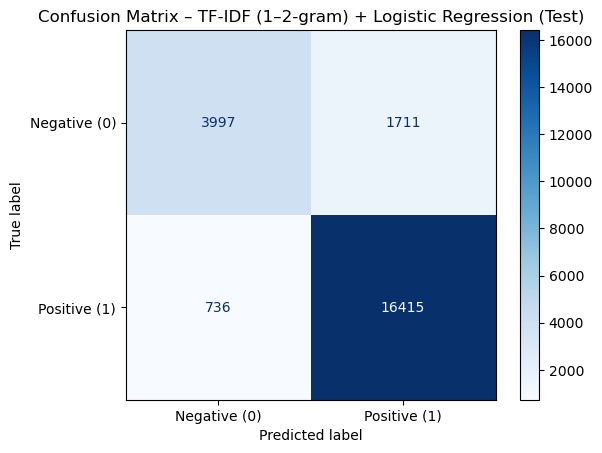

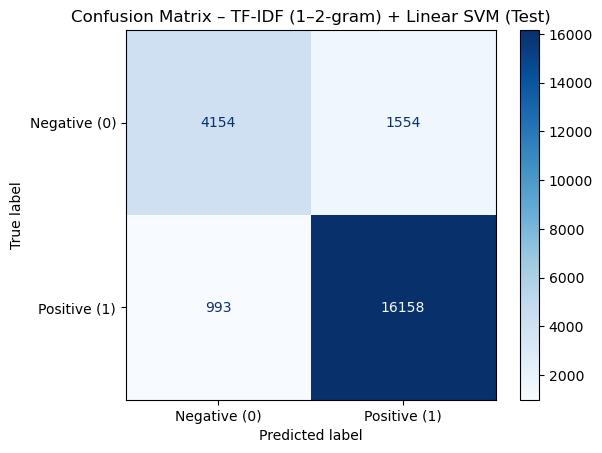

In [55]:
from sklearn.metrics import ConfusionMatrixDisplay

# Confusion matrix for TF-IDF + Logistic Regression (test set)
disp_lr = ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_test_pred,
    display_labels=["Negative (0)", "Positive (1)"],
    cmap="Blues",
    values_format="d",
)
plt.title("Confusion Matrix – TF-IDF (1–2-gram) + Logistic Regression (Test)")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

# Confusion matrix for TF-IDF + Linear SVM (test set)
disp_svm = ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_test_pred_svm,
    display_labels=["Negative (0)", "Positive (1)"],
    cmap="Blues",
    values_format="d",
)
plt.title("Confusion Matrix – TF-IDF (1–2-gram) + Linear SVM (Test)")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()


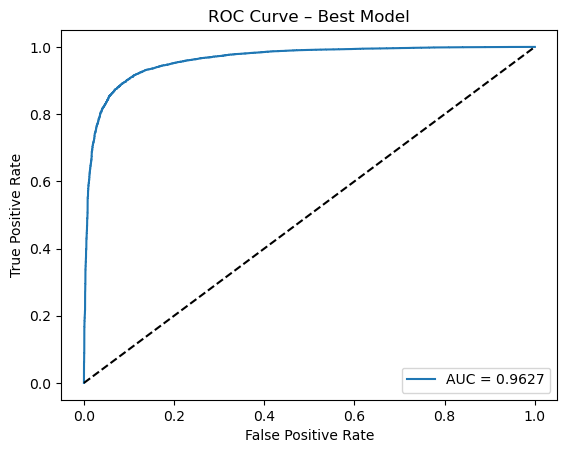

In [57]:
from sklearn.metrics import roc_curve, auc
best_model = models["tfidf_uni_bi_l2"]
best_proba = best_model.predict_proba(X_valid)[:, 1]

fpr, tpr, _ = roc_curve(y_valid, best_proba)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Best Model")
plt.legend()
plt.show()



In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

for m in [majority, best_lr_model, svm_model]:
    ConfusionMatrixDisplay.from_predictions(y_valid, m.predict(X_valid))
    plt.title(m.name)
    plt.show()


### 4. Baseline vs Model Performance

The majority-class baseline achieves ~75% accuracy, but this is misleading because it predicts 
the positive class for every example and completely fails to detect negatives (0% recall).

In contrast, the TF-IDF + Logistic Regression model achieves ~89% accuracy and an F1 of ~0.93, 
showing that even simple text features offer a substantial improvement. Linear SVM achieves 
similar performance, but bigram-enhanced Logistic Regression remains the strongest model overall.


,model,acc_test,prec_test,rec_test,f1_test,auc_test
5,tfidf_uni_bi_l2,0.902445,0.963471,0.904262,0.932928,0.960852
1,TF-IDF (1–2-gram) + LogReg (saved model),0.892952,0.905605,0.957087,0.930635,0.939434
6,tfidf_uni_bi_l1,0.898946,0.963173,0.899714,0.930363,0.959229
2,TF-IDF (1–2-gram) + Linear SVM,0.888578,0.912263,0.942103,0.926943,NaN
3,tfidf_uni_l2,0.876898,0.958080,0.874176,0.914207,0.945609
4,tfidf_uni_l1,0.876110,0.957681,0.873477,0.913643,0.945822
0,Majority baseline,0.750295,0.750295,1.000000,0.857336,0.500000


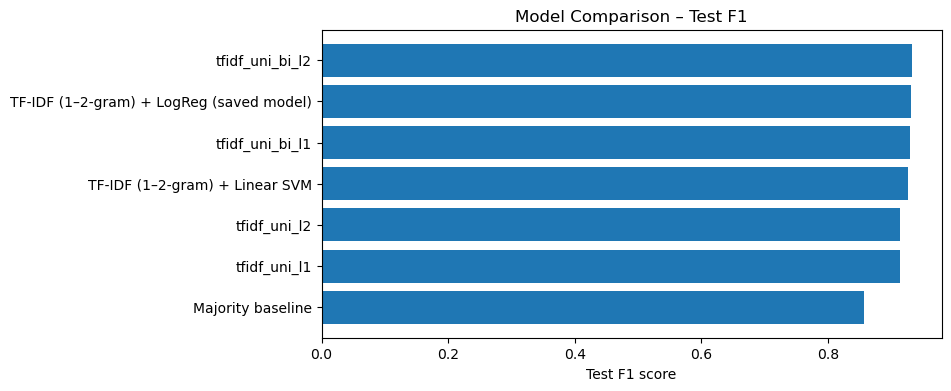

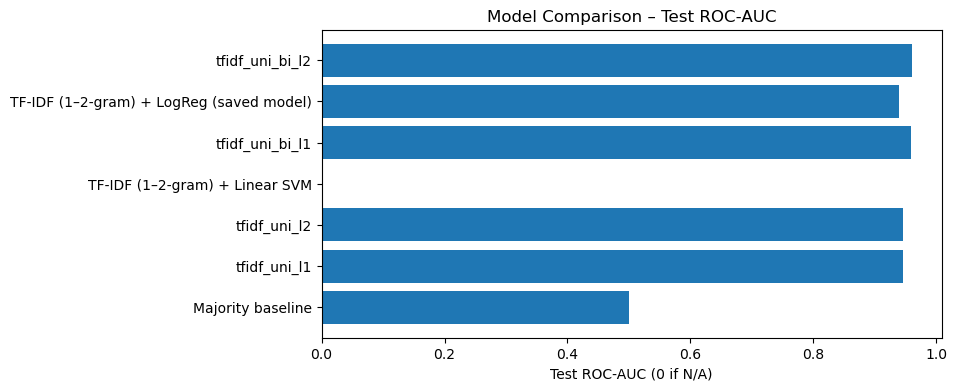

In [48]:
# 4. Baseline vs. Model Performance – comparison table

summary_rows = []

# Majority baseline (recompute for test set)
y_test_maj = np.full_like(y_test, majority_class)
prec, rec, f1, _ = precision_recall_fscore_support(
    y_test, y_test_maj, average="binary", zero_division=0
)
summary_rows.append(
    {
        "model": "Majority baseline",
        "acc_test": accuracy_score(y_test, y_test_maj),
        "prec_test": prec,
        "rec_test": rec,
        "f1_test": f1,
        "auc_test": 0.5,  # random guess
    }
)

# Original TF-IDF + LogReg from earlier cells (clf / y_test_pred / y_test_proba)
prec, rec, f1, _ = precision_recall_fscore_support(
    y_test, y_test_pred, average="binary", zero_division=0
)
summary_rows.append(
    {
        "model": "TF-IDF (1–2-gram) + LogReg (saved model)",
        "acc_test": accuracy_score(y_test, y_test_pred),
        "prec_test": prec,
        "rec_test": rec,
        "f1_test": f1,
        "auc_test": roc_auc_score(y_test, y_test_proba),
    }
)

# Linear SVM (no probabilities, so no AUC)
prec, rec, f1, _ = precision_recall_fscore_support(
    y_test, y_test_pred_svm, average="binary", zero_division=0
)
summary_rows.append(
    {
        "model": "TF-IDF (1–2-gram) + Linear SVM",
        "acc_test": accuracy_score(y_test, y_test_pred_svm),
        "prec_test": prec,
        "rec_test": rec,
        "f1_test": f1,
        "auc_test": np.nan,
    }
)

# Add the 4 extra TF-IDF + LogReg variants
summary_rows.extend(extra_results.to_dict(orient="records"))

results_df = pd.DataFrame(summary_rows)
results_df = results_df.sort_values("f1_test", ascending=False)

display(results_df)

# Simple visualization: F1 and AUC by model
plt.figure(figsize=(8, 4))
plt.barh(results_df["model"], results_df["f1_test"])
plt.xlabel("Test F1 score")
plt.title("Model Comparison – Test F1")
plt.gca().invert_yaxis()
plt.show()

plt.figure(figsize=(8, 4))
plt.barh(results_df["model"], results_df["auc_test"].fillna(0))
plt.xlabel("Test ROC-AUC (0 if N/A)")
plt.title("Model Comparison – Test ROC-AUC")
plt.gca().invert_yaxis()
plt.show()


In [ ]:
feature_names = np.array(vectorizer.get_feature_names_out())
coefs = clf.coef_[0]

top_pos_idx = np.argsort(coefs)[-20:]
top_neg_idx = np.argsort(coefs)[:20]

top_pos_words = pd.DataFrame({
    "word": feature_names[top_pos_idx],
    "coef": coefs[top_pos_idx]
}).sort_values("coef", ascending=False)

top_neg_words = pd.DataFrame({
    "word": feature_names[top_neg_idx],
    "coef": coefs[top_neg_idx]
}).sort_values("coef", ascending=True)

print("Top positive words:")
display(top_pos_words)

print("\nTop negative words:")
display(top_neg_words)


Top positive words:


,word,coef
19,love,16.882162
18,perfect,11.115012
17,great,10.212931
16,amazing,9.709341
15,best,8.260222
14,awesome,7.938312
13,loves,7.780892
12,excellent,7.746340
11,glad,7.385425
10,compliments,6.683499



Top negative words:


,word,coef
0,disappointed,-8.808137
1,worst,-8.459611
2,return,-7.627454
3,disappointing,-7.622148
4,horrible,-7.293662
5,returning,-7.130944
6,terrible,-6.977661
7,useless,-6.817698
8,broke,-6.663719
9,awful,-6.553039


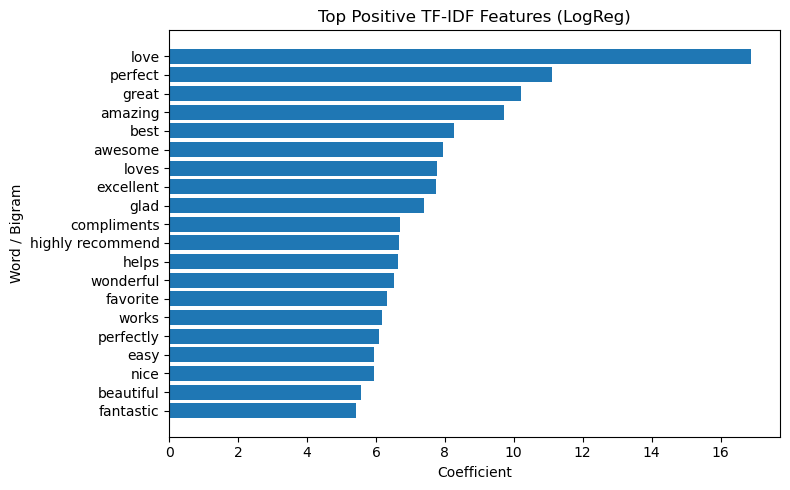

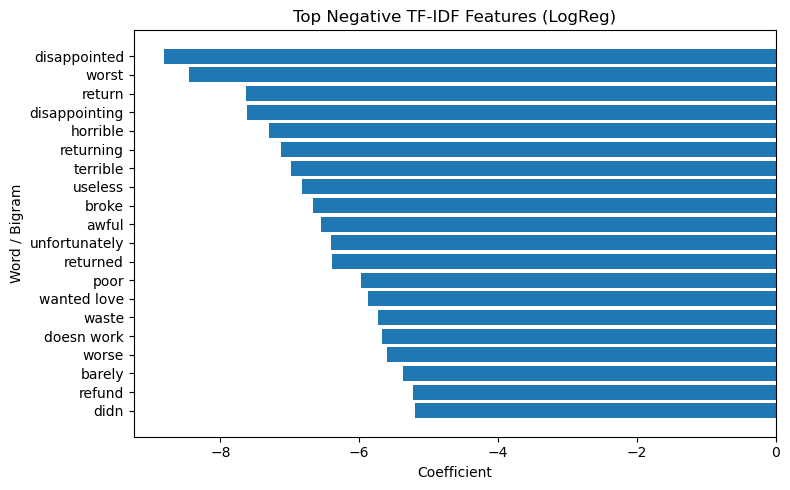

In [59]:
# Bar plot for top positive words
plt.figure(figsize=(8, 5))
plt.barh(top_pos_words["word"], top_pos_words["coef"])
plt.title("Top Positive TF-IDF Features (LogReg)")
plt.xlabel("Coefficient")
plt.ylabel("Word / Bigram")
plt.gca().invert_yaxis()  # largest at top
plt.tight_layout()
plt.show()

# Bar plot for top negative words
plt.figure(figsize=(8, 5))
plt.barh(top_neg_words["word"], top_neg_words["coef"])
plt.title("Top Negative TF-IDF Features (LogReg)")
plt.xlabel("Coefficient")
plt.ylabel("Word / Bigram")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


These coefficients confirm expected sentiment patterns. Strong positive weights correspond to 
clear approval terms (love, perfect, highly recommend), while negative coefficients 
indicate dissatisfaction (disappointed, worst, returning, doesn’t work). 

This interpretability is an advantage of linear models compared to transformer-based models.


## 5. Limitations and Future Work

**Limitations:**
- The dataset is skewed toward positive reviews (~75% positive), so even a naive baseline performs moderately well.
- TF–IDF ignores word order and long-range dependencies in text.
- We do not use additional metadata (price, brand, images), which could help disambiguate borderline cases.
- Some reviews may be sarcastic, ambiguous, or off-topic, which is challenging for simple text models.

**Potential improvements:**
- Use a transformer-based model (e.g., DistilBERT) fine-tuned on a subset of Beauty reviews.
- Incorporate review metadata (verified purchase, helpful votes) as extra features.
- Explore calibration techniques to better interpret predicted probabilities.
- Train per-subcategory models (e.g., skincare vs haircare) to capture more specific patterns.


## 6. Conclusion

We framed sentiment analysis for **Amazon Beauty & Personal Care** reviews as a binary classification problem.

- **Baseline:** A majority-class baseline achieves ~75% accuracy but fails to identify negative reviews.
- **Model:** A TF–IDF + Logistic Regression classifier substantially improves performance:
  - ~89% accuracy on the test set
  - ROC–AUC around 0.94
  - Much better balance between precision and recall for both classes

Despite its simplicity, text models performs strongly on large-scale review data and is computationally efficient and interpretable.